In [1]:
import pandas as pd
import numpy as np
from ln_utils import *
from transaction_simulator import *

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

### WHAT TO DO WITH INF-s???

In [3]:
experiment_id = "2019-05-30_18:55:02_100000sat_k10000"
snapshots = range(7)
simulation_dir = "/mnt/idms/fberes/data/bitcoin_ln_research/simulations/"

In [4]:
experiment_files = get_experiment_files(experiment_id, snapshots, simulation_dir)

In [5]:
all_infos = []
for snap_id in snapshots:
    info, df = aggregate_samples(experiment_files, snap_id)
    all_infos.append(info)
    print(snap_id)

0
1
2
3
4
5
6


all_infos[0]

### Average correlation (over time) between cost changes and other metric

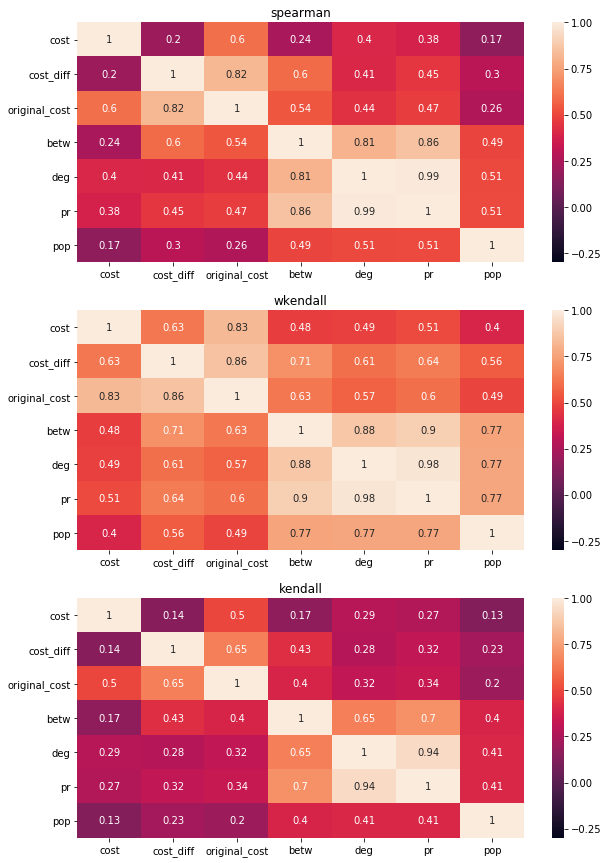

In [6]:
methods = ["spearman","wkendall","kendall"]
fig, axis = plt.subplots(len(methods), 1, figsize=(10,15))
for i, m in enumerate(methods):
    mx = corr_mx(all_infos[0].drop("removed_node", axis=1), method=m)
    for j in range(1,len(all_infos)):
        mx = np.add(mx, corr_mx(all_infos[j].drop("removed_node", axis=1), method=m))
    axis[i].set_title(m)
    sns.heatmap(mx / len(all_infos), annot=True, ax=axis[i], vmin=-0.3, vmax=1.0)

# Node analysis with 1ML background

In [10]:
from scrapy.crawler import CrawlerProcess
from scraping import *

### Average metrics of nodes

In [11]:
mean_all_info = pd.concat(all_infos, sort=True).groupby("removed_node").mean()
mean_all_info = mean_all_info.sort_values("cost_diff", ascending=False)

def show_df_with_alias(df):
    nodes = list(df.index)
    process = CrawlerProcess()
    process.crawl(LNNodeParser(nodes))
    process.start()
    print()

show_df_with_alias(mean_all_info.head(10))

In [14]:
mean_all_info.head(10)

,betw,cost,cost_diff,deg,original_cost,pop,pr
removed_node,,,,,,,
02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f0c544b34c1c6f3b9a02b,0.138629,1369.553236,513.785768,1910.857143,1883.339004,17.285714,0.018232
0331f80652fb840239df8dc99205792bba2e559a05469915804c08420230e23c7c,0.112938,109.926012,372.629509,1368.857143,482.555521,49.285714,0.015948
0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,0.076237,123.537332,140.166357,1302.000000,263.703689,35.142857,0.012682
03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e400d4b9cfe93763aa26d,0.032756,416.646438,139.596026,910.857143,556.242465,16.285714,0.007428
03cb7983dc247f9f81a0fa2dfa3ce1c255365f7279c8dd143e086ca333df10e278,0.029006,75.261923,97.978624,700.571429,173.240546,7.714286,0.006586
03c436af41160a355fc1ed230a64f6a64bcbd2ae50f12171d1318f9782602be601,0.006406,71.381714,54.155813,319.428571,125.537526,8.142857,0.002605
0395033b252c6f40e3756984162d68174e2bd8060a129c0d3462a9370471c6d28f,0.027972,42.286389,52.934023,685.428571,95.220413,32.142857,0.005421
0327049d8d63f0c40193cdf3afc61817c8647808a4e482de0716fcef74e6d92ebf,0.023416,18.161746,46.453376,407.428571,64.615122,3.714286,0.004492
0391489a933ab83094d1af43b3df3e8c8d467474649361912f05211d0e68a28fc9,0.011732,9.239657,41.831449,336.857143,51.071106,10.142857,0.003113


In [16]:
mean_all_info.tail(10)

,betw,cost,cost_diff,deg,original_cost,pop,pr
removed_node,,,,,,,
02d7617044629514778fe063a5ea498b992ef65a2e7721648dc673983b3ba36264,0.000252,0.454545,0.0,62.0,0.454545,0.0,0.000427
02d24daeea8997ba343c5ed9938f171a08b77a1b6f108f4b81ff0164177a991e4a,0.000038,0.681818,0.0,23.0,0.681818,0.0,0.000264
02d0f53a403a0b16efdec1983a082ab7645e35858f6a855871e489c9992748a059,0.000004,0.757576,0.0,10.0,0.757576,0.0,0.000096
02cfda4768450a63d33120d08180a4aaf727a19d264262ddc88a6904b6f4766fd4,0.000009,0.312500,0.0,20.0,0.312500,0.0,0.000145
0236858df92172763f4c632d46b538b6ee97cadda01a1b2f94068953437b2962cc,0.000002,0.842391,0.0,20.0,0.842391,0.0,0.000143
02cb4c2d5c8e64c35dc1e046e0c2804de95b890de9fdfbbd549e45343fe35f9537,0.000005,0.076336,0.0,12.0,0.076336,0.0,0.000102
02c9b429d70f15300e79d73c999d34599b9f0c633b891afe2c72afdcb49d33800c,0.000101,0.476190,0.0,22.0,0.476190,1.0,0.000222
03aeca3b52e028b68c67d01a62eede65df55bda5cd04e4341ac42688d25fc151cd,0.000002,0.833333,0.0,6.0,0.833333,0.0,0.000101
02c781c49ad00b0f19ecbc6cfd3fc6441f157e7e66348485dfc130bc1d7457c87a,0.000021,2.117730,0.0,4.0,2.117730,0.0,0.000090
